<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>
Figure 1.1.a. Jupyter environment + Python notebooks

### Digital Earth Pacific Notebook 1 Train Random Forest Machine Learning (ML) Model

<font color='green'>The objective of this notebook is to train a machine learning model that will allow us to classify an area with the land cover classes defined through the training data. </font>

<font color='blue'>Setup libaries</font>

In [2]:
from pystac_client import Client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
import utils
from utils import load_data
from utils import mask_and_scale
from sklearn.ensemble import RandomForestClassifier
import odc.geo.xr
import rioxarray
import matplotlib.pyplot as plt

<font color='blue'>Define catalogue</font>

In [3]:
catalogue = "https://earth-search.aws.element84.com/v1"
client = Client.open(catalogue)

<font color='red'>Define your area of interest - copy and paste the bottom left latitude (min_lat) and the bottem left longitude (min_lon) and the top right latitude (max_lat) and the top right longitude (max_lon)

<font color='red'>In this activity you can use the following examples: 
`-18.1313, -18.1553, 177.4347, 177.4032`
  
<font color='red'>  Note we have reordered these into the wrong order so you will have to define them correctly below:</font>

In [17]:
min_lat = -18.279530
min_lon = 178.142327
max_lat = -18.254355
max_lon = 178.169476

bbox = [min_lon, min_lat, max_lon, max_lat]

<font color='red'>Define your time of interest - choose a range of a few months in 2024 using the syntax `datetime="YYYY-MM/YYYY-MM"`</font>

In [28]:
datetime="2024-01/2024-12"

<font color='red'>Connect to parallel computers for greater computational capacity - note you should only run this line of code once per notebook activity - do not rerun this line</font>

In [29]:
dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')

configure_s3_access(cloud_defaults=True, requester_pays=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45017 instead
  warnings.warn(


<font color='green'>Define your training data by entering the name of the data marine_tdata_yanuca_rf.geojson and the column of your attribute table you wish to read the data from noting this should be an integer. First enter the full file name including format inside the brackets `("file.geojson")` . Next you will have to name the column properly `column="column_name"`</font>

In [30]:
# # Define training data
# # 1
# gdf = gpd.read_file("")

# gdf = gdf.to_crs("EPSG:4326")

# # 2
# gdf.explore(column="", legend=True)


<font color='green'>Count the number of points in your dataset using the function `print(len(variable))`</font>

<font color='green'>Search through the catalogue - define the cloud cover threshold you want. Try changing 80 to 50 here: `{"lt": 50}},` </font>

In [31]:
# Search through catalogue for relevant data
items = client.search(
    collections=["sentinel-2-c1-l2a"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover":{"lt": 30}},
).item_collection()

print(f"Found {len(items)} items")


Found 35 items


<font color='blue'>Load your satellite dataset based on your search parameters defined above</font>

In [32]:
# data = utils.load_data
data = load_data(items, bbox)

<font color='blue'>Set scale and masks and consider the dataset information below including the bands used for analysis:</font>

In [33]:
scaled = mask_and_scale(data)
scaled

<xarray.Dataset> Size: 148MB
Dimensions:      (time: 35, y: 281, x: 290)
Coordinates:
  * y            (y) float64 2kB 7.981e+06 7.981e+06 ... 7.979e+06 7.978e+06
  * x            (x) float64 2kB 6.207e+05 6.208e+05 ... 6.236e+05 6.236e+05
    spatial_ref  int32 4B 32760
  * time         (time) datetime64[ns] 280B 2024-01-01T22:31:04.983000 ... 20...
Data variables: (12/13)
    red          (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    green        (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    blue         (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    nir08        (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    swir16       (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    scl          (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    ...           ...
    nir09        (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    cloud        (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    rededge1     (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    rededge3     (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    rededge2     (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>
    nir          (time, y, x) float32 11MB dask.array<chunksize=(1, 281, 290), meta=np.ndarray>

<font color='blue'>Explore the satellite image dataset you have loaded</font>

In [44]:
scaled.isel(time=0).odc.explore(bands=("red", "green", "blue"), vmin=0, vmax=0.3)


<font color='blue'>Generate a median image dataset</font>

In [45]:
median = scaled.median("time").compute()
median_image = median.assign_coords(band=["coastal", "red", "green", "blue", "nir", "swir1", "swir2"])

<font color='red'>The formula for the Normalized Difference Turbidity Index (NDTI) is: 

<font color='red'>\(NDTI=(Red-Green)/(Red+Green)\)

<font color='red'>Define a variable to store NDTI using the median xarray dataset

In [46]:
ndti = (median_image["red"]+median_image["green"])/(median_image["red"]-median_image["green"])

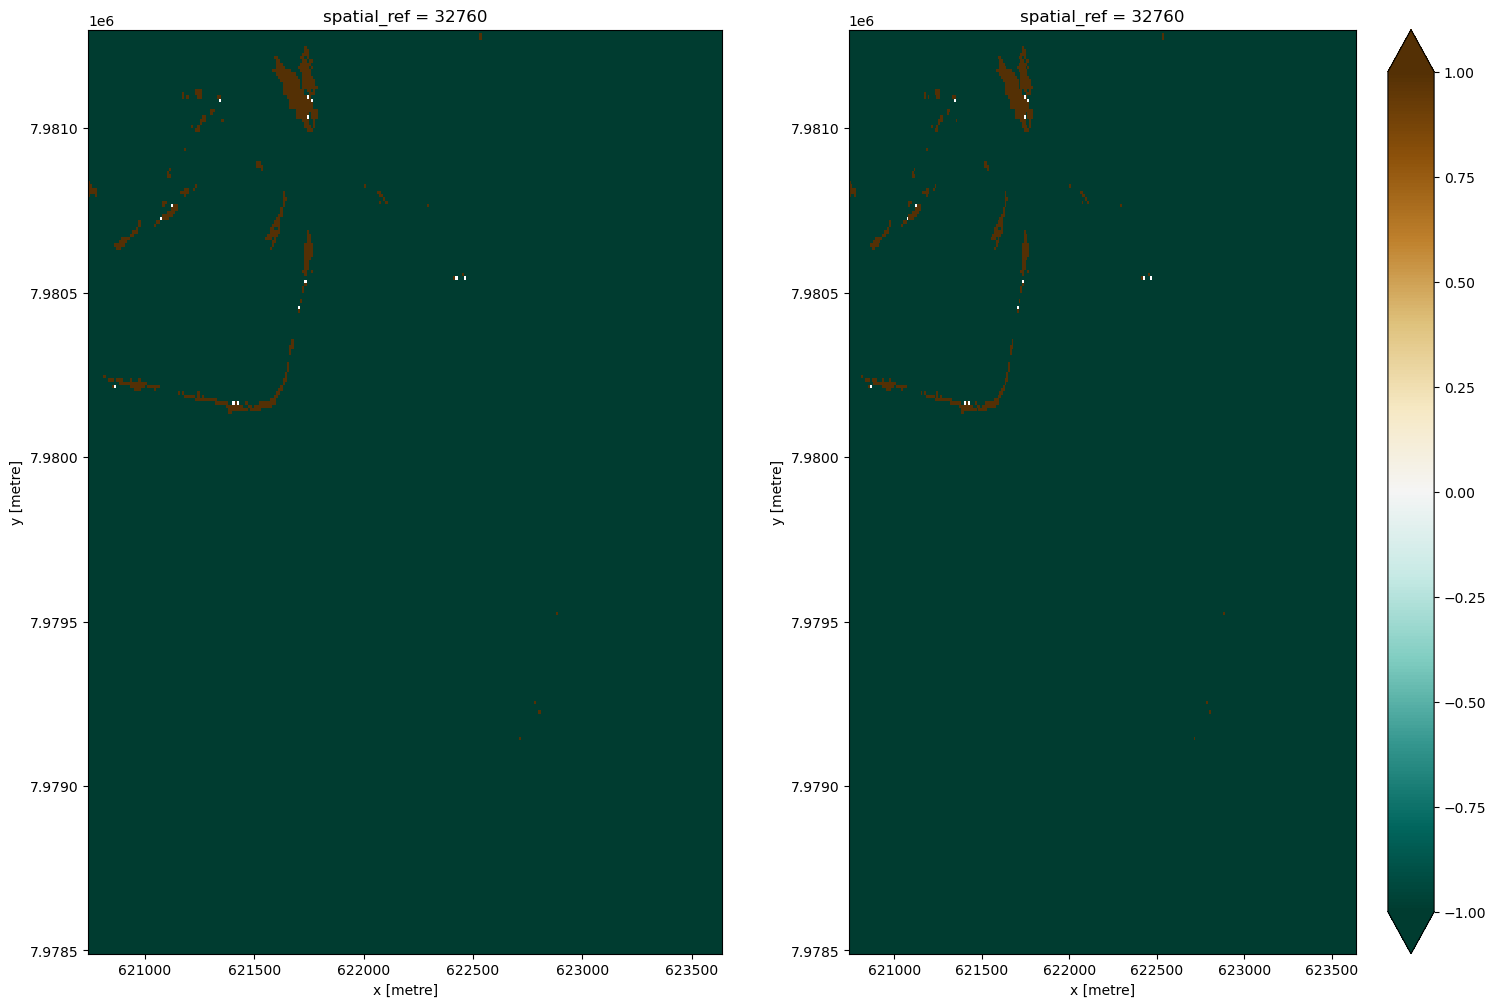

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
cmap='BrBG_r'
vmin=-1
vmax=1

ndti.plot(ax=ax[0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
ndti.plot(ax=ax[1], cmap=cmap, add_colorbar=True, vmin=vmin, vmax=vmax);

In [40]:
scaled.isel(time=3).odc.explore(bands=("red", "green", "blue"), vmin=0, vmax=0.3)


In [48]:
turbid = scaled.isel(time=3)
turbid = turbid.assign_coords(band=["coastal", "red", "green", "blue", "nir", "swir1", "swir2"])

In [55]:
ndti_turbid = (turbid["red"]+turbid["green"])/(turbid["red"]-turbid["green"])

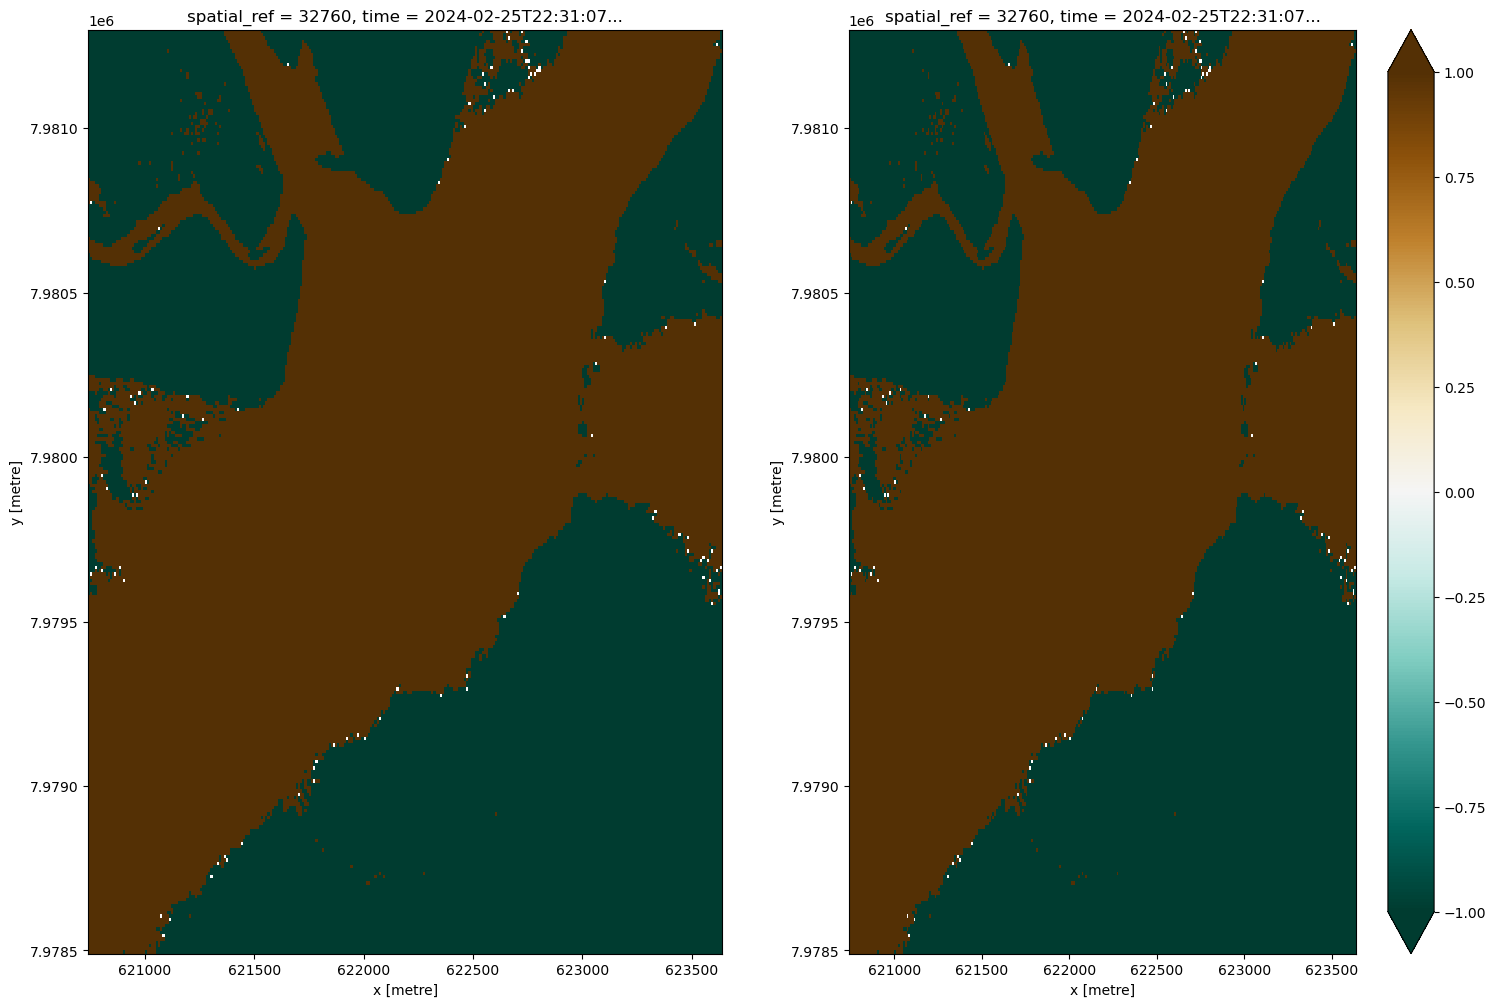

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
cmap='BrBG_r'
vmin=-1
vmax=1

ndti_turbid.plot(ax=ax[0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
ndti_turbid.plot(ax=ax[1], cmap=cmap, add_colorbar=True, vmin=vmin, vmax=vmax);

In [56]:
ndti_turbid.odc.explore(cmap='BrBG_r', vmin=-1, vmax=1)


<font color='red'>Generate and visualise a mask to exclude land from your analysis. Note, inside the  rio.open() function enter the Near Infrared file using the syntex : `rio.open('median_nir.tif')`</font>

In [27]:
# Open the raster file
with rio.open('') as src:
    band = src.read(1)  # Read the first band (e.g., NIR)
    
land_mask = band < 0.2
masked_raster = np.ma.masked_where(~land_mask, band)
masked_raster_da = xr.DataArray(masked_raster)
masked_raster_da.plot.imshow(origin="upper")

<font color='red'>How and why do you think we use Near Infrared to mask out the land area? Consider figure 2 in your reasoning. This will be a question for discussion. Include some of your notes below:</font>

<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/NIR.jpg?raw=true" width="900"/>
Figure 2. Near infrared reflectance across different land cover types. 

Notes go here:






<font color='blue'>Configure your input training labelled GPS points to train your machine learning model</font>

In [14]:
# First transform the training points to the same CRS as the data
training = gdf.to_crs(median.odc.geobox.crs)

# Next get the X and Y values out of the point geometries
training_da = training.assign(x=training.geometry.x, y=training.geometry.y).to_xarray()

# Now we can use the x and y values (lon, lat) to extract values from the median composite
training_values = (
    median.sel(training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)



<font color='red'>Run this code and look at the table generated including information about the different spectral band values. You wil need to input the column name inside `training["column name"]`</font>

In [30]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training[""], training_values], axis=1)
training_array = training_array.drop(
    columns=[
        "y",
        "x",
        "spatial_ref",
    ]
)

# Drop rows where there was no data available
training_array = training_array.dropna()

# Preview our resulting training array
training_array.head()

<font color='blue'>Train the machine learning model</font>

In [16]:
# The classes are the first column
classes = np.array(training_array)[:, 0]

# The observation data is everything after the first column
observations = np.array(training_array)[:, 1:]

# Create a model...
classifier = RandomForestClassifier()

# ...and fit it to the data
model = classifier.fit(observations, classes)

<font color='blue'>Prepare the outputs for visualisation</font>

In [17]:
# Convert to a stacked array of observations
stacked_arrays = median.to_array().stack(dims=["y", "x"]).transpose()

# Predict the classes
predicted = model.predict(stacked_arrays)

# Reshape back to the original 2D array
array = predicted.reshape(len(median.y), len(median.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    array, coords={"y": median.y, "x": median.x}, dims=["y", "x"]
)

In [18]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

float64


<font color='blue'>Visualise the output</font>

In [31]:
# Put it all on a single interactive map
# center = [np.mean([min_lat[0], max_lat[0]]), np.mean([min_lat[1], max_lat[1]])]
# m = folium.Map(location=center, zoom_start=11)

center = [(min_lat + max_lat) / 2, (min_lon + max_lon) / 2]  # Assuming min_lon and max_lon are defined
m = folium.Map(location=center, zoom_start=13)



# RGB for the median
median.odc.to_rgba(bands=("red", "green", "blue"), vmin=0, vmax=0.3).odc.add_to(m, name="Median Composite")


# Categorical for the predicted classes and for the training data
predicted_da.odc.add_to(m, name="Predicted")
gdf.explore(m=m, column="class_id", legend=True, name="Training Data")

# Layer control
folium.LayerControl().add_to(m)

m

<font color='blue'>Write the resulting output to a tif file you can download and open in QGIS</font>

In [20]:
predicted_da.odc.write_cog("predicted_randomforest_model_1.tif", overwrite=True)

PosixPath('predicted_randomforest_model_1.tif')

<font color='blue'>Mask out land from your analysis to focus on the coastal ocean in this example</font>

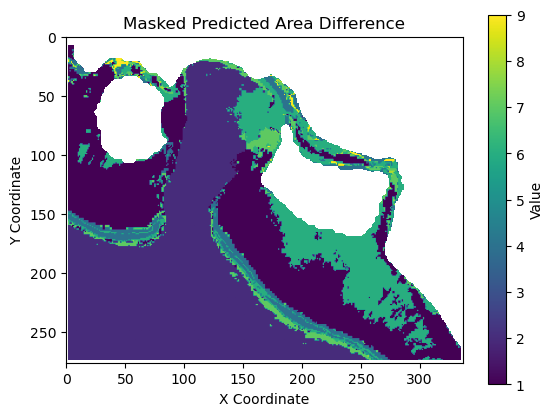

In [21]:
with rio.open("masked_predicted_area_difference.tif") as src:
    band = src.read(1)

# Plot the data
plt.imshow(band, cmap="viridis")  # Choose a colormap, e.g., "viridis"
plt.colorbar(label="Value")  # Add a colorbar for reference
plt.title("Masked Predicted Area Difference")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

### Congratulations you have completed this activity. Let the instructors know if you have any questions. Otherwise, move onto the next activity 

<font color='green'>The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data. </font>

<font color='blue'>Finished</font>

In [22]:
print("Finished, well done")

Finished, well done
